In [2]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, RobertaTokenizer, set_seed

In [3]:
%cd ..

/home/vmadmin/project


In [4]:
seed = 42
set_seed(seed)

Set the paths according to the wanted experiment:

In [5]:
MODEL = 'amazon/bort'
# TRAIN_PATH = 'data/classifier_data/random_real_train.csv'
# TEST_PATH = 'data/classifier_data/random_real_test.csv'
# TRAIN_PATH = 'data/classifier_data/tfidf_real_train.csv'
# TEST_PATH = 'data/classifier_data/tfidf_real_test.csv'
TRAIN_PATH = 'data/classifier_data/generated_real_train.csv'
TEST_PATH = 'data/classifier_data/generated_real_test.csv'
STRONG_TEST_PATH = 'data/classifier_data/random_real_test.csv'

# Read and process the data:

In [6]:
data_files = {
    'train': TRAIN_PATH,
    'test': TEST_PATH,
    'test_strong': STRONG_TEST_PATH
}
raw_datasets = load_dataset("csv", data_files=data_files)

Using custom data configuration default-67c0c3487951b97e
Reusing dataset csv (/home/vmadmin/.cache/huggingface/datasets/csv/default-67c0c3487951b97e/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
from utils import SpecialTokens
def connect_columns(company_data):
    company_data['training_text'] = company_data['company_name'] + SpecialTokens.IND_SEP + company_data['industry'] + SpecialTokens.TEXT_SEP + company_data['text']
    return company_data
raw_datasets = raw_datasets.map(connect_columns)

  0%|          | 0/80000 [00:00<?, ?ex/s]

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/20000 [00:00<?, ?ex/s]

In [8]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL)
tokenized_datasets = raw_datasets.map(tokenizer, input_columns='text',
                                      fn_kwargs={"max_length": 512,
                                                 "truncation": True,
                                                 "padding": "max_length",
                                                 "add_special_tokens": True,
                                                 "return_special_tokens_mask": False,
                                                 "return_token_type_ids": False,
                                                 "return_attention_mask": True})
tokenized_datasets.set_format('torch')
for split in tokenized_datasets:
    tokenized_datasets[split] = tokenized_datasets[split].add_column('label', raw_datasets[split]['label'])

  0%|          | 0/80000 [00:00<?, ?ex/s]

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/20000 [00:00<?, ?ex/s]

# Set metric function and training arguments:

In [9]:
save_path = None

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
import matplotlib.pyplot as plt

def metric_fn(predictions):
    preds = predictions.predictions.argmax(axis=1)
    labels = predictions.label_ids
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'recall: {recall_score(labels, preds)}')
    plt.savefig(save_path)
    plt.show()
    return {'recall': recall_score(labels, preds)}

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)
trainer_args = TrainingArguments(
    f"models/roberta-base-classifier",
    push_to_hub=False,
    num_train_epochs=3,
    seed=seed,
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    disable_tqdm=False,
    save_total_limit=10
)

Some weights of the model checkpoint at amazon/bort were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at amazon/bort and are newly initial

# Train and evaluate:

In [12]:
trainer = Trainer(
    model=model,
    args=trainer_args,
    train_dataset=tokenized_datasets['train'],
    compute_metrics=metric_fn
)

print("Training...")
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 80000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 30000


Training...


Step,Training Loss


Saving model checkpoint to models/roberta-base-classifier/checkpoint-500
Configuration saved in models/roberta-base-classifier/checkpoint-500/config.json
Model weights saved in models/roberta-base-classifier/checkpoint-500/pytorch_model.bin
Deleting older checkpoint [models/roberta-base-classifier/checkpoint-27000] due to args.save_total_limit
Saving model checkpoint to models/roberta-base-classifier/checkpoint-1000
Configuration saved in models/roberta-base-classifier/checkpoint-1000/config.json
Model weights saved in models/roberta-base-classifier/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to models/roberta-base-classifier/checkpoint-1500
Configuration saved in models/roberta-base-classifier/checkpoint-1500/config.json
Model weights saved in models/roberta-base-classifier/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to models/roberta-base-classifier/checkpoint-2000
Configuration saved in models/roberta-base-classifier/checkpoint-2000/config.json
Model weig

TrainOutput(global_step=30000, training_loss=0.4000177607218425, metrics={'train_runtime': 10893.9131, 'train_samples_per_second': 22.031, 'train_steps_per_second': 2.754, 'total_flos': 1.781438496768e+16, 'train_loss': 0.4000177607218425, 'epoch': 3.0})

In [13]:
save_path = 'data/classifier_data/gpt2_weak_test_CM.png'

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


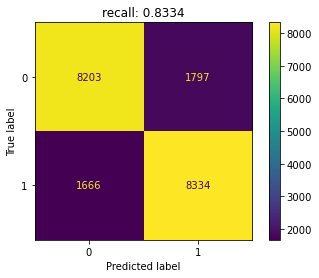

{'eval_loss': 0.6497917175292969,
 'eval_recall': 0.8334,
 'eval_runtime': 272.2256,
 'eval_samples_per_second': 73.468,
 'eval_steps_per_second': 9.184,
 'epoch': 3.0}

In [14]:
trainer.evaluate(tokenized_datasets['test'])

In [15]:
save_path = 'data/classifier_data/gpt2_strong_test_CM.png'

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


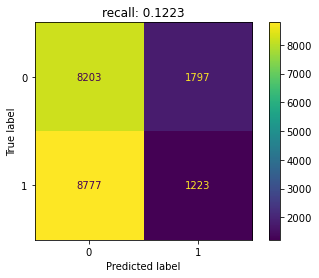

{'eval_loss': 2.55733060836792,
 'eval_recall': 0.1223,
 'eval_runtime': 272.7952,
 'eval_samples_per_second': 73.315,
 'eval_steps_per_second': 9.164,
 'epoch': 3.0}

In [16]:
trainer.evaluate(tokenized_datasets['test_strong'])

In [17]:
import mlflow
mlflow.end_run()